> Se analiza una base de datos que contiene información sobre el balance
hídrico de la subcuenca hidrográfica RH12Ec (Jalisco), estructurada a nivel mensual para cada Unidad de
Respuesta Hidrológica (HRU) en el período comprendido entre 2013 y 2024.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
df = pd.read_csv('/Users/elikenneth/Downloads/tabla_hru.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010160 entries, 0 to 1010159
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   HRUGIS      1010160 non-null  int64  
 1   YEAR        1010160 non-null  int64  
 2   MON         1010160 non-null  int64  
 3   AREAkm2     1010160 non-null  float64
 4   PRECIPmm    1010160 non-null  float64
 5   PERCmm      1010160 non-null  float64
 6   SURQ_GENmm  1010160 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 53.9 MB


In [4]:
df.head()

,HRUGIS,YEAR,MON,AREAkm2,PRECIPmm,PERCmm,SURQ_GENmm
0,10001,2013,1,0.020709,73.7,0.000,33.120
1,10002,2013,1,0.097504,73.7,3.279,33.479
2,10003,2013,1,0.191980,73.7,0.000,32.500
3,10004,2013,1,0.010006,73.7,0.000,0.000
4,10005,2013,1,0.003251,73.7,0.000,0.000


> Para calcular el volumen por hectárea tanto de infiltración como de escurrimiento para
cada mes de cada año:

In [6]:
def calcular_volumenes(df):
    
    años = df['YEAR'].unique()

    dataframes = []

    for i in años:
        df_filtrado = df[df['YEAR'] == i]
        suma = df_filtrado.groupby('MON').sum()
        vol = pd.DataFrame({
            'Volumen_Infiltración (m3)': (suma['PERCmm'] * 10000) / 1000,
            'Volumen_Escurrimiento (m3)': (suma['SURQ_GENmm'] * 10000) / 1000
        })

        dataframes.append(vol)

    años_str = [str(i) for i in años]
    df_final = pd.concat(dataframes, keys = años_str).round(2)
    df_final.index.names = ['Año', 'Mes']
    return(df_final)

In [7]:
volumenes = calcular_volumenes(df)
volumenes

Volumen_Infiltración (m3)  Volumen_Escurrimiento (m3)
Año  Mes                                                       
2013 1                    481642.99                  1922366.61
     2                         8.86                        0.00
     3                         0.00                        0.00
     4                         0.00                        0.00
     5                         0.00                    15422.62
...                             ...                         ...
2024 8                    511044.91                  1547927.61
     9                    184539.35                   897957.95
     10                    45545.26                   540846.23
     11                      243.15                    10154.45
     12                        0.00                     7316.19

[144 rows x 2 columns]

> Para analizar la tendencia en función de la precipitación e identificar patrones
significativos:

In [9]:
def graficar_precipitacion(df, ruta_1, ruta_2):

    años = df['YEAR'].unique()
    años_str = [str(i) for i in años]
    prom_año = df.groupby(by='YEAR')[['PRECIPmm']].mean().round(2)
    prom_año = prom_año.reset_index()

    sbn.set_theme(style="ticks")

    sbn.lineplot(x="YEAR", y="PRECIPmm",
                 data=prom_año)
    plt.xticks(prom_año["YEAR"].unique(), rotation=45)
    plt.title(f'Precipitación media anual histórica ({años_str[0]}-{años_str[-1]})',
              fontsize=14,
              fontweight="bold")
    plt.xlabel("Año")
    plt.ylabel("Precipitación (mm)")

    plt.tight_layout()
    plt.savefig(ruta_1);

    list_prom_mes = []

    for i in años:
        df_filtrado = df[df['YEAR'] == i]
        prom_año = df_filtrado.groupby(by='MON').mean().round(2)
        list_prom_mes.append(prom_año)

    df_prom_mes = pd.concat(list_prom_mes,
                            keys=años_str)
    df_prom_mes = df_prom_mes.reset_index()
    df_prom_mes = df_prom_mes.rename(columns={"level_0": "AÑO",
                                              'MON': 'MES'})
    df_prom_mes = df_prom_mes.drop(columns='YEAR')

    meses = {
        1: "Ene", 2: "Feb", 3: "Mar", 4: "Abr",
        5: "May", 6: "Jun", 7: "Jul", 8: "Ago",
        9: "Sep", 10: "Oct", 11: "Nov", 12: "Dic"
    }
    df_prom_mes["MES"] = df_prom_mes["MES"].map(meses)

    #
    #

    sbn.set_theme(style="ticks")

    g = sbn.relplot(
        data=df_prom_mes,
        x="MES", y="PRECIPmm", col="AÑO", hue="AÑO",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=3, height=2, aspect=1.5, legend=False,
    )

    for year, ax in g.axes_dict.items():
        ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

        sbn.lineplot(
            data=df_prom_mes, x="MES", y="PRECIPmm", units="AÑO",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    ax.set_xticks(ax.get_xticks()[::2])

    g.set_titles("")
    g.set_axis_labels("Meses", "Precipitación (mm)")
    g.fig.suptitle(f'Precipitación media mensual histórica ({años_str[0]}-{años_str[-1]})',
                   fontsize=14,
                   fontweight="bold")
    g.tight_layout()
    g.savefig(ruta_2);

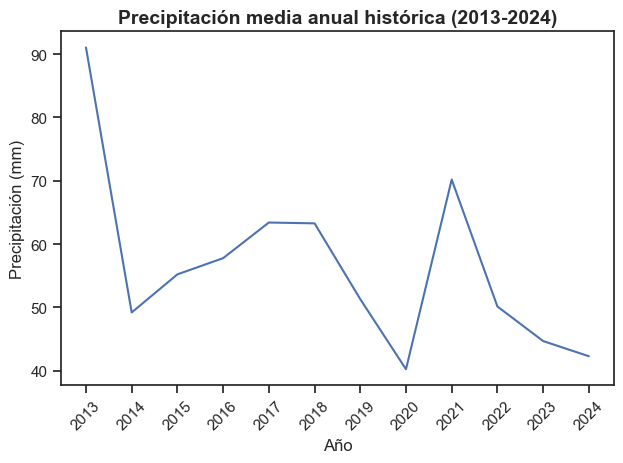

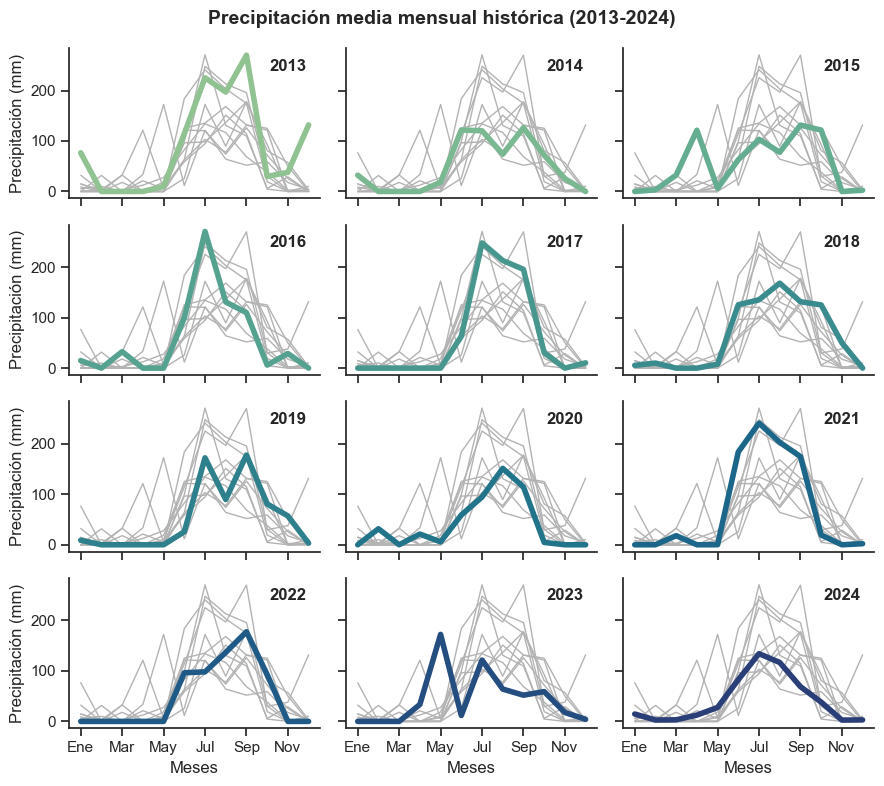

In [10]:
graficar_precipitacion(df, "/Users/elikenneth/Desktop/precip_año_prom.png", "/Users/elikenneth/Desktop/precip_men_prom.png")